In [ ]:
from tvDatafeed import TvDatafeed, Interval
import pandas as pd
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# Подключение
tv = TvDatafeed()


In [15]:
def get_stock_data(ticker, exchange="NASDAQ", interval=Interval.in_daily, bars=1000):
    df = tv.get_hist(ticker, exchange, interval=interval, n_bars=bars)
    if df is None or df.empty:
        raise ValueError(f"Нет данных для {ticker}")
    return df['close']


In [ ]:
tickers = ['AAPL', 'MSFT', 'GOOGL']  # можешь поменять на свои
data = {}

for ticker in tickers:
    close_prices = get_stock_data(ticker, bars=10000)
    data[ticker] = close_prices

prices_df = pd.DataFrame(data)
prices_df.dropna(inplace=True)
# prices_df


In [27]:
prices_df

,AAPL,MSFT,GOOGL
datetime,,,
2004-08-19 18:30:00,0.548392,27.12000,2.510808
2004-08-20 18:30:00,0.549999,27.20000,2.710377
2004-08-23 18:30:00,0.554999,27.24001,2.737653
2004-08-24 18:30:00,0.570535,27.24001,2.624293
2004-08-25 18:30:00,0.590178,27.55000,2.652570
...,...,...,...
2025-04-07 18:30:00,181.460000,357.86000,146.750000
2025-04-08 18:30:00,172.420000,354.56000,144.700000
2025-04-09 18:30:00,198.850000,390.49000,158.710000


In [24]:
prices_df.isna().sum()

AAPL     0
MSFT     0
GOOGL    0
dtype: int64

In [25]:
prices_df.describe()

,AAPL,MSFT,GOOGL
count,5196.000000,5196.000000,5196.000000
mean,54.628110,110.797117,49.629556
std,65.887064,121.248378,48.195701
min,0.548392,15.150000,2.502675
25%,6.857226,27.840000,13.241768
50%,24.688024,44.100000,28.351000
75%,70.844375,161.680000,66.973500
max,259.020000,467.560000,206.380000


In [26]:
prices_df.tail()


,AAPL,MSFT,GOOGL
datetime,,,
2025-04-07 18:30:00,181.46,357.86,146.75
2025-04-08 18:30:00,172.42,354.56,144.70
2025-04-09 18:30:00,198.85,390.49,158.71
2025-04-10 18:30:00,190.42,381.35,152.82
2025-04-11 18:30:00,198.15,388.45,157.14


In [28]:
returns = prices_df.pct_change().dropna()
returns.head()


,AAPL,MSFT,GOOGL
datetime,,,
2004-08-20 18:30:00,0.002930,0.002950,0.079484
2004-08-23 18:30:00,0.009091,0.001471,0.010064
2004-08-24 18:30:00,0.027993,0.000000,-0.041408
2004-08-25 18:30:00,0.034429,0.011380,0.010775
2004-08-26 18:30:00,0.048714,-0.003993,0.018019


In [29]:
def optimize_portfolio(returns, risk_aversion=3.0):
    mu = returns.mean() * 252  # годовая доходность
    cov = returns.cov() * 252  # годовая ковариация
    n = len(mu)

    def utility(w):
        return -(mu @ w - (risk_aversion / 2) * w.T @ cov @ w)

    bounds = [(0.0, 1.0) for _ in range(n)]
    constraints = [{'type': 'eq', 'fun': lambda w: np.sum(w) - 1}]
    x0 = np.ones(n) / n

    result = minimize(utility, x0, method='SLSQP', bounds=bounds, constraints=constraints)

    if not result.success:
        raise RuntimeError(result.message)

    return {
        'weights': result.x,
        'expected_return': mu @ result.x,
        'volatility': np.sqrt(result.x.T @ cov @ result.x)
    }


In [30]:
opt_result = optimize_portfolio(returns)

for ticker, weight in zip(tickers, opt_result['weights']):
    print(f"{ticker}: {weight:.2%}")

print(f"\nОжидаемая доходность: {opt_result['expected_return']:.2%}")
print(f"Ожидаемая волатильность: {opt_result['volatility']:.2%}")


AAPL: 75.00%
MSFT: 0.00%
GOOGL: 25.00%

Ожидаемая доходность: 31.62%
Ожидаемая волатильность: 29.21%


In [38]:
import numpy as np

start_weight = np.array([0.33, 0.33, 0.33])
optimized_weight = np.array(opt_result['weights'])  # оптимизация


In [ ]:
# Расчёт кумулятивного роста
def compute_cumulative_growth(returns, weights):
    port_returns = returns.dot(weights)
    cumulative = (1 + port_returns).cumprod()
    return cumulative * 100  # нормализация

original_cum = compute_cumulative_growth(returns, start_weight)
optimized_cum = compute_cumulative_growth(returns, optimized_weight)


In [ ]:
original_cum.iloc[:]

datetime
2004-08-20 18:30:00     102.817019
2004-08-23 18:30:00     103.516832
2004-08-24 18:30:00     103.058572
2004-08-25 18:30:00     104.982960
2004-08-26 18:30:00     107.156566
                          ...     
2025-04-07 18:30:00    8185.771491
2025-04-08 18:30:00    7988.552050
2025-04-09 18:30:00    8915.042735
2025-04-10 18:30:00    8612.279424
2025-04-11 18:30:00    8860.905260
Length: 5195, dtype: float64

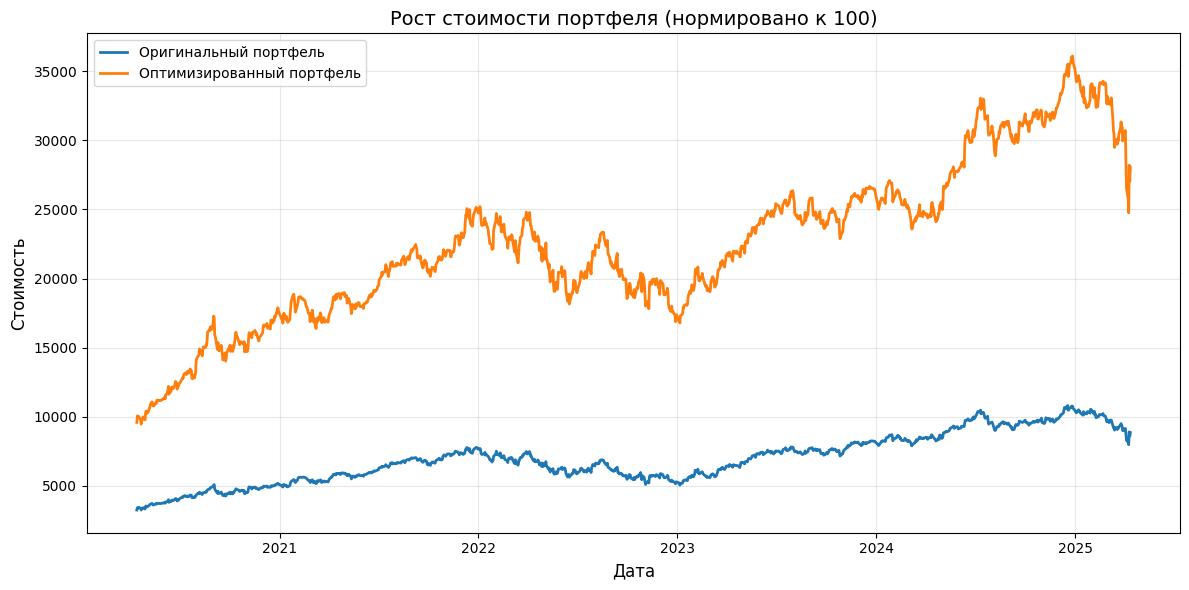

In [60]:
# График

start, end = -200, -1
start_date, end_date = '2020-04-13', '2025-04-11'

plt.figure(figsize=(12, 6))
plt.plot(original_cum.loc[start_date:end_date], label='Оригинальный портфель', linewidth=2)
plt.plot(optimized_cum.loc[start_date:end_date], label='Оптимизированный портфель', linewidth=2)
plt.title('Рост стоимости портфеля (нормировано к 100)', fontsize=14)
plt.ylabel('Стоимость', fontsize=12)
plt.xlabel('Дата', fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()